# 📊 Multi-Device Anomaly Detection Pipeline
**Improved Feature Mapping for Varying Sensor Structures**


Processing device: bale_counter

bale_counter - Auto-detected features: ['average_weight', 'bales', 'total_weight']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Threshold for ../test_cases/saved_models/lstm_off_bale_counter.h5: 0.000050


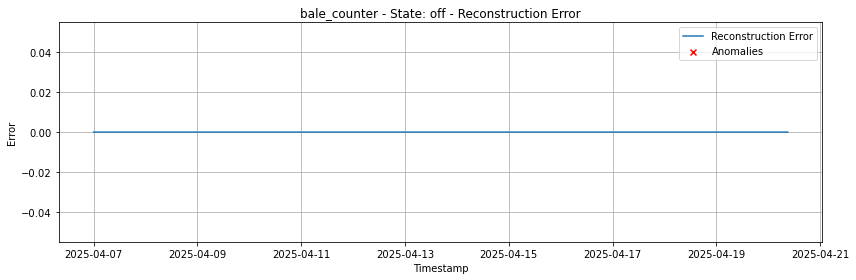

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Threshold for ../test_cases/saved_models/lstm_idle_bale_counter.h5: 0.012410


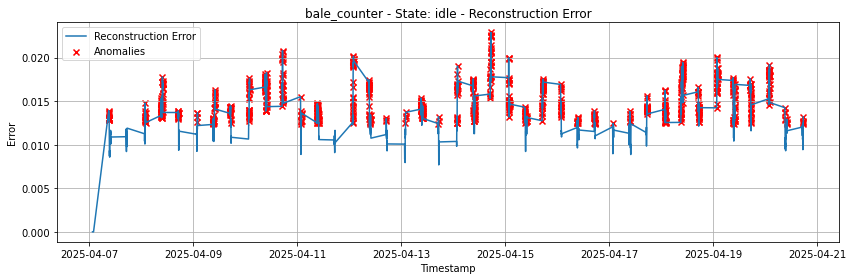

518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Threshold for ../test_cases/saved_models/lstm_run_bale_counter.h5: 0.003284


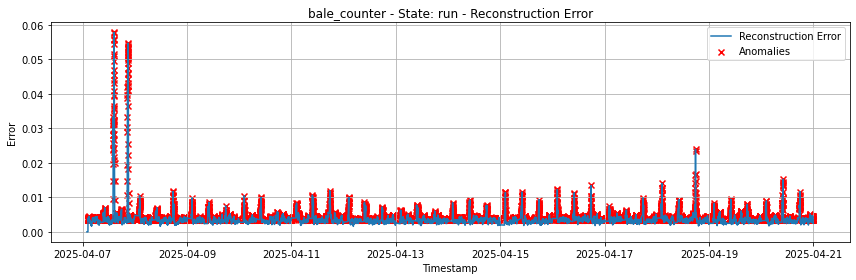

⏱️ Time taken for bale_counter: 5.98 seconds
💾 Memory usage after bale_counter: 589.25 MB


Processing device: motor_monitor

motor_monitor - Auto-detected features: ['power', 'rpm', 'temperature', 'vibration']
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Threshold for ../test_cases/saved_models/lstm_off.h5: 0.029661


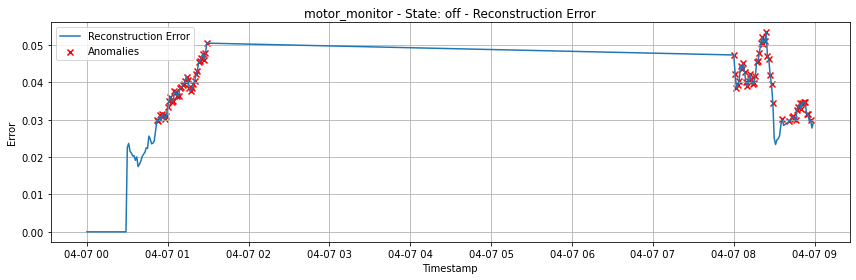

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Threshold for ../test_cases/saved_models/lstm_idle.h5: 0.044436


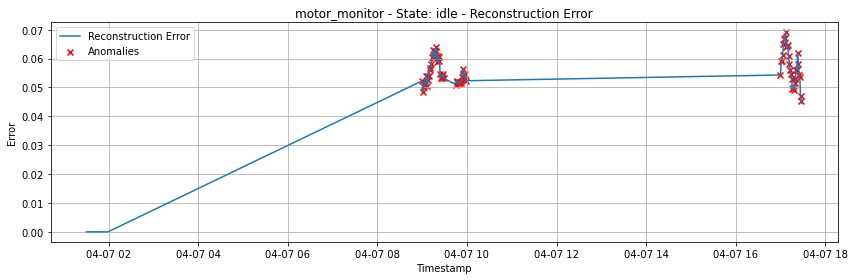

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Threshold for ../test_cases/saved_models/lstm_run.h5: 8.897947


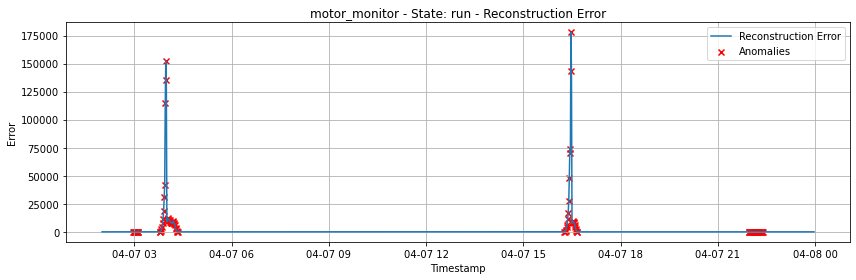

⏱️ Time taken for motor_monitor: 2.68 seconds
💾 Memory usage after motor_monitor: 564.70 MB


Processing device: output_sensor

output_sensor - Auto-detected features: ['output']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Threshold for ../test_cases/saved_models/lstm_long_fiber.h5: 0.013152


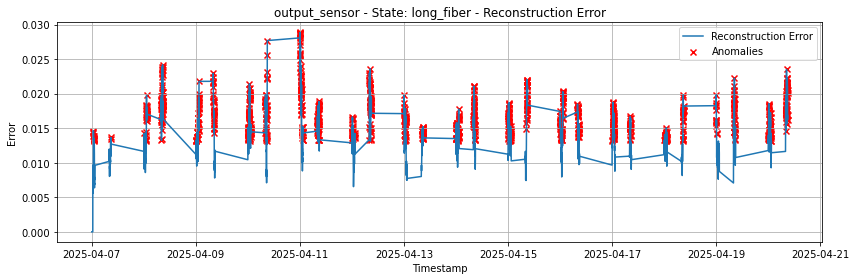

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Threshold for ../test_cases/saved_models/lstm_short_fiber.h5: 0.017260


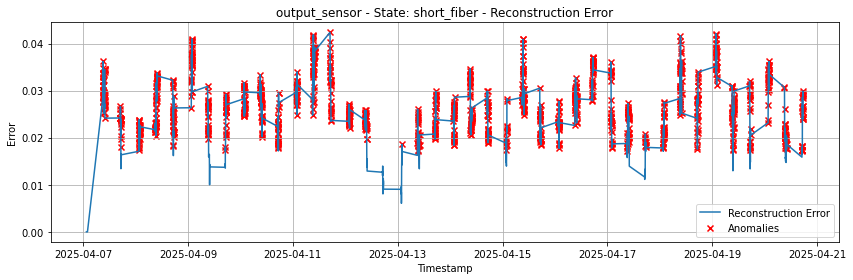

518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Threshold for ../test_cases/saved_models/lstm_hurd.h5: 0.000098


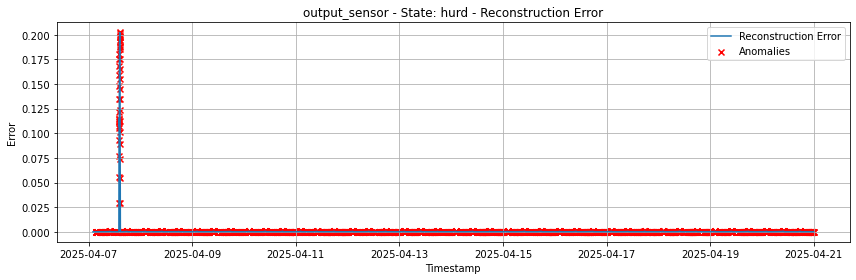

⏱️ Time taken for output_sensor: 5.65 seconds
💾 Memory usage after output_sensor: 589.55 MB


Processing device: temperature_sensor

temperature_sensor - Auto-detected features: ['temperatureSensor1']
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Threshold for ../test_cases/saved_models/lstm_off_temperature_sensor.h5: 0.000050


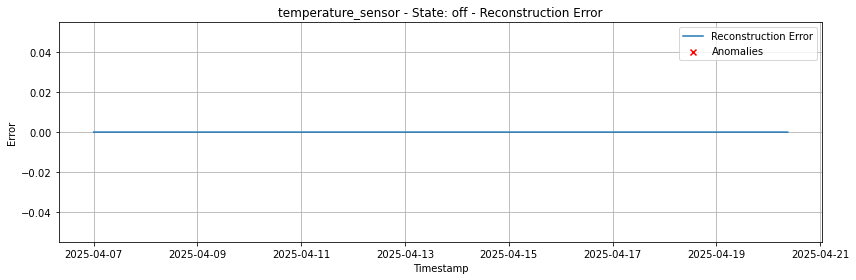

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Threshold for ../test_cases/saved_models/lstm_idle_temperature_sensor.h5: 0.000050


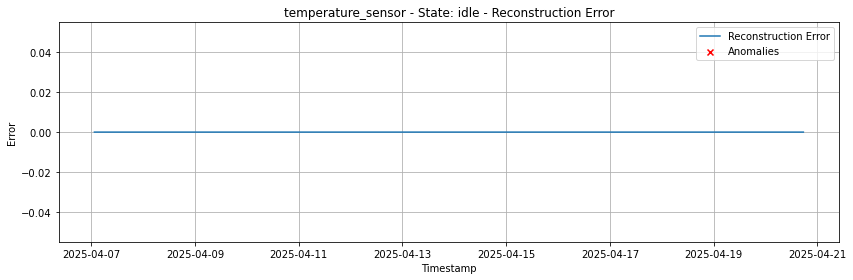

518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Threshold for ../test_cases/saved_models/lstm_run_temperature_sensor.h5: 0.000468


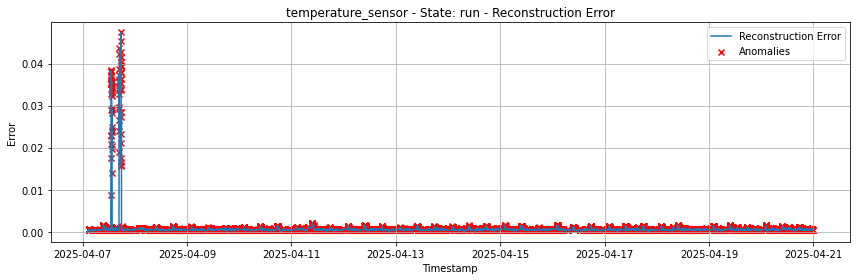

⏱️ Time taken for temperature_sensor: 5.46 seconds
💾 Memory usage after temperature_sensor: 607.02 MB


✅ Processing complete for all devices!
⏱️ Total Execution Time: 19.77 seconds
💾 Start Memory: 555.41 MB
💾 End Memory: 607.02 MB
📈 Total Memory Growth: 51.61 MB


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import time
import psutil  # NEW: to monitor memory usage

# Paths
DEVICES_DATA_PATH = "../src/devices_data/"
SAVED_MODELS_PATH = "../test_cases/saved_models/"

# Columns to exclude from auto feature detection
EXCLUDE_COLUMNS = ['timestamp', 'state', 'reconstruction_error', 'is_anomaly', 'label']

# NEW: Start timers and memory tracking
global_start_time = time.time()
process = psutil.Process(os.getpid())
start_memory = process.memory_info().rss / (1024 * 1024)  # in MB

def get_model_name(device_type, state):
    if device_type == 'bale_counter':
        return f"lstm_{state}_bale_counter.h5"
    elif device_type == 'temperature_sensor':
        return f"lstm_{state}_temperature_sensor.h5"
    elif device_type == 'output_sensor':
        return f"lstm_{state}.h5"
    else:
        return f"lstm_{state}.h5"

def get_rf_model_name(device_type):
    if device_type == 'bale_counter':
        return "random_forest_bale.pkl"
    elif device_type == 'output_sensor':
        return "random_forest_output_sensor.pkl"
    elif device_type == 'temperature_sensor':
        return "random_forest_temperature_sensor.pkl"
    return None

def get_device_files():
    device_files = []
    for file in os.listdir(DEVICES_DATA_PATH):
        if file.endswith("_unified.csv"):
            device_type = file.split('_')[0] + '_' + file.split('_')[1]
            if device_type == "hatch_status":  # ✅ SKIP hatch_status
                continue
            device_files.append((device_type, file))
    return device_files

def get_numerical_features(df):
    return [col for col in df.columns if col not in EXCLUDE_COLUMNS and pd.api.types.is_numeric_dtype(df[col])]

def create_sequences(data, seq_length=30):
    return np.array([data.iloc[i:i + seq_length].values for i in range(len(data) - seq_length)])

def detect_state_anomalies(df_state, model_path, feature_cols):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_state[feature_cols])

    model = load_model(model_path, compile=False)
    if scaled.shape[1] != model.input_shape[-1]:
        print(f"⚠️ Feature count mismatch: model expects {model.input_shape[-1]}, but got {scaled.shape[1]}")
        return df_state

    sequences = create_sequences(pd.DataFrame(scaled))
    reconstructions = model.predict(sequences)
    errors = np.mean((reconstructions - sequences[:, -reconstructions.shape[1]:, :]) ** 2, axis=(1, 2))

    hist, bins = np.histogram(errors, bins=10000)
    mode_index = np.argmax(hist)
    threshold = (bins[mode_index] + bins[mode_index + 1]) / 2
    print(f"Threshold for {model_path}: {threshold:.6f}")

    flags = np.array([False] * len(df_state))
    flags[30:len(errors) + 30] = errors > threshold
    df_state['reconstruction_error'] = [0.0] * 30 + errors.tolist()
    df_state['is_anomaly'] = flags
    return df_state

def process_device(device_type, csv_file):
    print(f"\n{'=' * 50}")
    print(f"Processing device: {device_type}")
    print(f"{'=' * 50}\n")

    # NEW: Timer for this device
    device_start_time = time.time()

    try:
        df = pd.read_csv(os.path.join(DEVICES_DATA_PATH, csv_file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])

        available_features = get_numerical_features(df)
        if not available_features:
            print(f"⚠️ {device_type} - No numerical sensor features detected in data.")
            return None

        print(f"{device_type} - Auto-detected features: {available_features}")
        df_all = pd.DataFrame()

        for state in df['state'].unique():
            model_name = get_model_name(device_type, state)
            model_path = os.path.join(SAVED_MODELS_PATH, model_name)

            if not os.path.exists(model_path):
                print(f"⚠️ No model file found for {device_type} - State: {state} -> {model_name}. Skipping.")
                continue

            df_state = df[df['state'] == state].copy()
            df_state_processed = detect_state_anomalies(df_state, model_path, available_features)

            if 'reconstruction_error' in df_state_processed.columns:
                df_all = pd.concat([df_all, df_state_processed])

                plt.figure(figsize=(12, 4))
                plt.plot(df_state_processed['timestamp'], df_state_processed['reconstruction_error'], label='Reconstruction Error')
                plt.scatter(
                    df_state_processed[df_state_processed['is_anomaly']]['timestamp'],
                    df_state_processed[df_state_processed['is_anomaly']]['reconstruction_error'],
                    color='red', label='Anomalies', marker='x'
                )
                plt.title(f"{device_type} - State: {state} - Reconstruction Error")
                plt.xlabel("Timestamp")
                plt.ylabel("Error")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"⚠️ Skipping state '{state}' for {device_type} due to detection failure.")

        if df_all.empty:
            return None

        df_all = df_all.sort_values('timestamp').reset_index(drop=True)
        df_encoded = pd.get_dummies(df_all, columns=["state"])
        for col in ["state_off", "state_run", "state_idle"]:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

    

        # NEW: After device finished
        device_end_time = time.time()
        print(f"⏱️ Time taken for {device_type}: {device_end_time - device_start_time:.2f} seconds")
        mem_usage = process.memory_info().rss / (1024 * 1024)
        print(f"💾 Memory usage after {device_type}: {mem_usage:.2f} MB\n")

        return df_all

    except Exception as e:
        print(f"❌ Error processing {device_type}: {str(e)}")
        return None

# 🚀 Main execution
device_files = get_device_files()
all_results = {}

for device_type, csv_file in device_files:
    result = process_device(device_type, csv_file)
    if result is not None:
        all_results[device_type] = result

# NEW: Final global stats
global_end_time = time.time()
end_memory = process.memory_info().rss / (1024 * 1024)

print("\n✅ Processing complete for all devices!")
print(f"⏱️ Total Execution Time: {global_end_time - global_start_time:.2f} seconds")
print(f"💾 Start Memory: {start_memory:.2f} MB")
print(f"💾 End Memory: {end_memory:.2f} MB")
print(f"📈 Total Memory Growth: {end_memory - start_memory:.2f} MB")
